In [171]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [172]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler

In [173]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot

import shap
from catboost import CatBoostRegressor, Pool

plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 500)

pyplot.rcParams["figure.figsize"] = (20,10)

In [174]:
import matplotlib.pyplot as plt
def trading(forecast,actual):
#execute the trading from the result of forecast and actual energy production
#forecast: an 1D array of forecast values (Unit:kWh)
#actual: an 1D array of actual values (Unit:kWh)
  
    #initial budget
    budget=1e9
    #counters initialize: short falling and panalty counter
    SFcount=0;
    Pcount=0;
    cashFlow=[1e9]
    
    for f,a in zip(forecast,actual):
        if f <= a:
            budget += f*10
        elif f > a:#short falling
            #calculate cost of spot price energy
            budget += a*10
            spotP = 20*(f-a)
            SFcount+= 1
            if budget >= spotP:
                budget -= 20*(f-a)
            else:
                #receive penalty from the government
                if budget>0:
                    #buy from grid if budget not equal to 0
                    spotP-=budget
                    budget=0
                #fine =5* spotP
                budget -= 5*spotP
                Pcount+=1
        cashFlow.append(budget)
    timeStep= list(range(0, len(cashFlow)))
    #Reporting
    plt.plot(timeStep,cashFlow)
    plt.show()
    print ("resultant budget: ",budget)
    print ("net profit: ",budget-1e9)
    print ("number of short falling: ",SFcount )
    print ("number of panalty: ",Pcount )
    #print ("Cash flow: ",cashFlow )

In [175]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [279]:
data = pd.read_csv("combined_energy_data.csv", low_memory=False)

In [280]:
data = data.drop_duplicates(subset=['datetime'])

In [281]:
data['datetime'] = data['datetime'].apply(lambda x: x.split("+")[0])

In [282]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [283]:
columns_use = ['datetime','Wind', 'guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)',
       'lieusaint_Speed(m/s)', 'lieusaint_Direction (deg N)',
       'lvs-pussay_Speed(m/s)', 'lvs-pussay_Direction (deg N)',
       'parc-du-gatinais_Speed(m/s)', 'parc-du-gatinais_Direction (deg N)',
       'arville_Speed(m/s)', 'arville_Direction (deg N)',
       'boissy-la-riviere_Speed(m/s)', 'boissy-la-riviere_Direction (deg N)',
       'angerville-1_Speed(m/s)', 'angerville-1_Direction (deg N)',
       'angerville-2_Speed(m/s)', 'angerville-2_Direction (deg N)',
       'guitrancourt-b_Speed(m/s)', 'guitrancourt-b_Direction (deg N)',
       'lieusaint-b_Speed(m/s)', 'lieusaint-b_Direction (deg N)',
       'lvs-pussay-b_Speed(m/s)', 'lvs-pussay-b_Direction (deg N)',
       'parc-du-gatinais-b_Speed(m/s)', 'parc-du-gatinais-b_Direction (deg N)',
       'arville-b_Speed(m/s)', 'arville-b_Direction (deg N)',
       'boissy-la-riviere-b_Speed(m/s)',
       'boissy-la-riviere-b_Direction (deg N)', 'angerville-1-b_Speed(m/s)',
       'angerville-1-b_Direction (deg N)', 'angerville-2-b_Speed(m/s)',
       'angerville-2-b_Direction (deg N)']

In [284]:
#agg_df = df[['datetime','Wind']].groupby([df['datetime'].dt.floor('H')]).agg(['mean','sum','std'])
#agg_df.columns = agg_df.columns.map('_'.join)
#agg_df = agg_df.reset_index()
#merge_df = agg_df.merge(df[columns_use], how='left', on='datetime')
#merge_df = merge_df.fillna(method='ffill')

In [285]:
#data = merge_df.copy()

In [286]:
data = data[columns_use].fillna(method='ffill')

In [287]:
data.dropna(inplace=True)

In [288]:
window = 29 
lag_size = 18
lag = lag_size

In [289]:
series = series_to_supervised(data, window=window, lag=lag).reset_index(drop=True)

In [290]:
datetime_t0 = series['datetime(t)']

In [291]:
datetime_cols = [c for c in series.columns if 'datetime' in c]

In [292]:
series.drop(datetime_cols, axis=1, inplace=True)

In [293]:
series['datetime'] = datetime_t0

In [294]:
series['hour'] = series['datetime'].dt.hour
series['dayofweek'] = series['datetime'].dt.dayofweek
series['quarter'] = series['datetime'].dt.quarter
series['month'] = series['datetime'].dt.month
series['year'] = series['datetime'].dt.year 
series['dayofyear'] = series['datetime'].dt.dayofyear
series['dayofmonth'] = series['datetime'].dt.day
series['weekofyear'] = series['datetime'].dt.weekofyear

In [295]:
plt.rcParams["figure.figsize"] = (20, 9)

In [296]:
scaler = StandardScaler()

In [297]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [298]:
y_train = series[series.year.isin([2017,2018])][['Wind(t+18)']]
y_test = series[series.year.isin([2019])][['Wind(t+18)']]
y_holdout = series[series.year.isin([2020])][['Wind(t+18)']]

In [299]:
leak_cols = [c for c in series.columns if '(t+%d)' % lag_size in c]

In [300]:
series.drop(leak_cols, axis=1, inplace=True)

In [301]:
X_train = scaler.fit_transform(series[series.year.isin([2017,2018])].drop(columns=['datetime','year','month']))
X_test = scaler.transform(series[series.year.isin([2019])].drop(columns=['datetime','year','month']))
X_holdout = scaler.transform(series[series.year.isin([2020])].drop(columns=['datetime','year','month']))

In [302]:
#X_train.drop(leak_cols, axis=1, inplace=True)
#X_test.drop(leak_cols, axis=1, inplace=True)
#X_holdout.drop(leak_cols, axis=1, inplace=True)

In [303]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_holdout_series = X_holdout.reshape((X_holdout.shape[0], X_holdout.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_test_series.shape)

Train set shape (70043, 996, 1)
Validation set shape (35036, 996, 1)


In [304]:
epochs = 40
batch = len(X_train_series)
lr = 0.0003
adam = optimizers.Adam(lr)

In [305]:
import keras.backend as K
def customLoss(true,pred):
    diff = pred - true

    greater = K.greater(diff,0)
    greater = K.cast(greater, K.floatx()) #0 for lower, 1 for greater
    greater = greater + 1                 #1 for lower, 2 for greater

    #use some kind of loss here, such as mse or mae, or pick one from keras
    #using mse:
    return K.mean(greater*K.square(diff))

In [306]:
reg = Sequential()
reg.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
reg.add(MaxPooling1D(pool_size=2))
reg.add(Flatten())
reg.add(Dense(50, activation='relu'))
reg.add(Dense(1))
reg.compile(loss=customLoss, optimizer=adam)
reg.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 995, 64)           192       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 497, 64)           0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 31808)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                1590450   
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 51        
Total params: 1,590,693
Trainable params: 1,590,693
Non-trainable params: 0
_________________________________________________________________


In [307]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [ ]:
cnn_history = reg.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=epochs, verbose=2, callbacks=[early_stopping_monitor])

Epoch 1/40
2189/2189 - 19s - loss: 12272086.0000 - val_loss: 33456988.0000
Epoch 2/40


In [268]:
y_pred = reg.predict(X_test_series)

In [269]:
np.sqrt(mean_squared_error(y_test,y_pred))

3225.6832595131827

In [270]:
mean_absolute_error(y_test,y_pred)

2272.3885852257904

In [289]:
series = series_to_supervised(data, window=window, lag=lag).reset_index(drop=True)

In [290]:
datetime_t0 = series['datetime(t)']

In [291]:
datetime_cols = [c for c in series.columns if 'datetime' in c]

In [292]:
series.drop(datetime_cols, axis=1, inplace=True)

In [293]:
series['datetime'] = datetime_t0

In [294]:
series['hour'] = series['datetime'].dt.hour
series['dayofweek'] = series['datetime'].dt.dayofweek
series['quarter'] = series['datetime'].dt.quarter
series['month'] = series['datetime'].dt.month
series['year'] = series['datetime'].dt.year 
series['dayofyear'] = series['datetime'].dt.dayofyear
series['dayofmonth'] = series['datetime'].dt.day
series['weekofyear'] = series['datetime'].dt.weekofyear

In [271]:
test_result = series[series.year.isin([2019])].copy()
test_result['prediction'] = y_pred

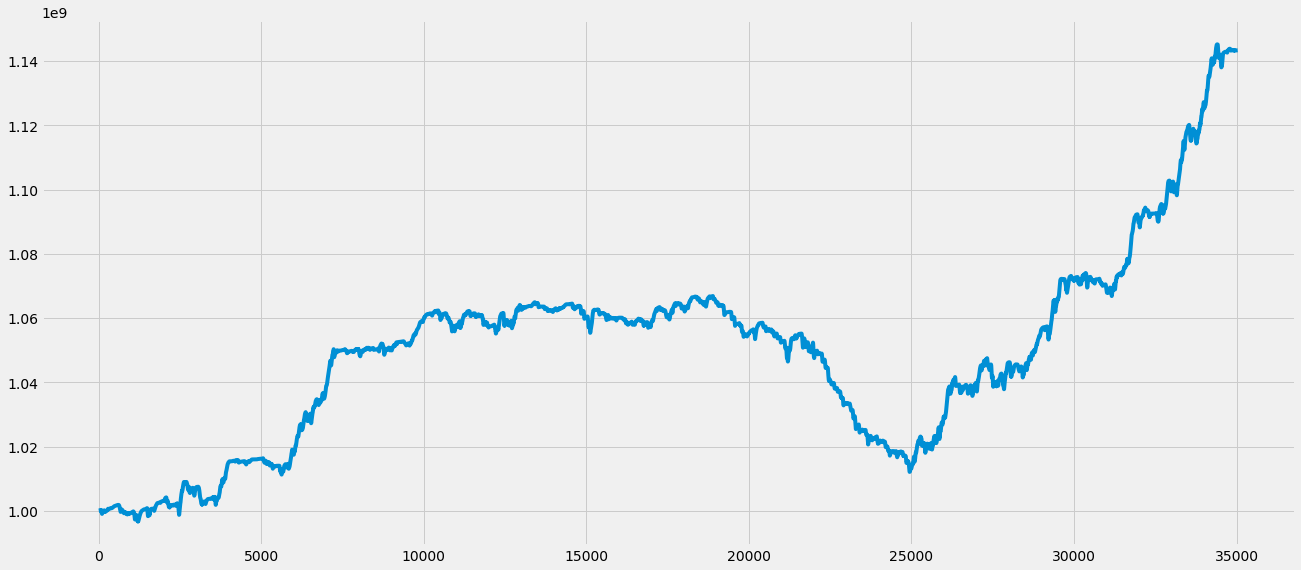

resultant budget:  1143408243.551762
net profit:  143408243.5517621
number of short falling:  19313
number of panalty:  0


In [272]:
trading(test_result['Wind(t+18)'], test_result.prediction)

In [273]:
y_holdout_pred = reg.predict(X_holdout_series)

In [274]:
np.sqrt(mean_squared_error(y_holdout,y_holdout_pred))

4246.339886044592

In [275]:
mean_absolute_error(y_holdout,y_holdout_pred)

3053.2850003569115

In [276]:
holdout_result = series[series.year.isin([2020])].copy()
holdout_result['prediction'] = y_holdout_pred

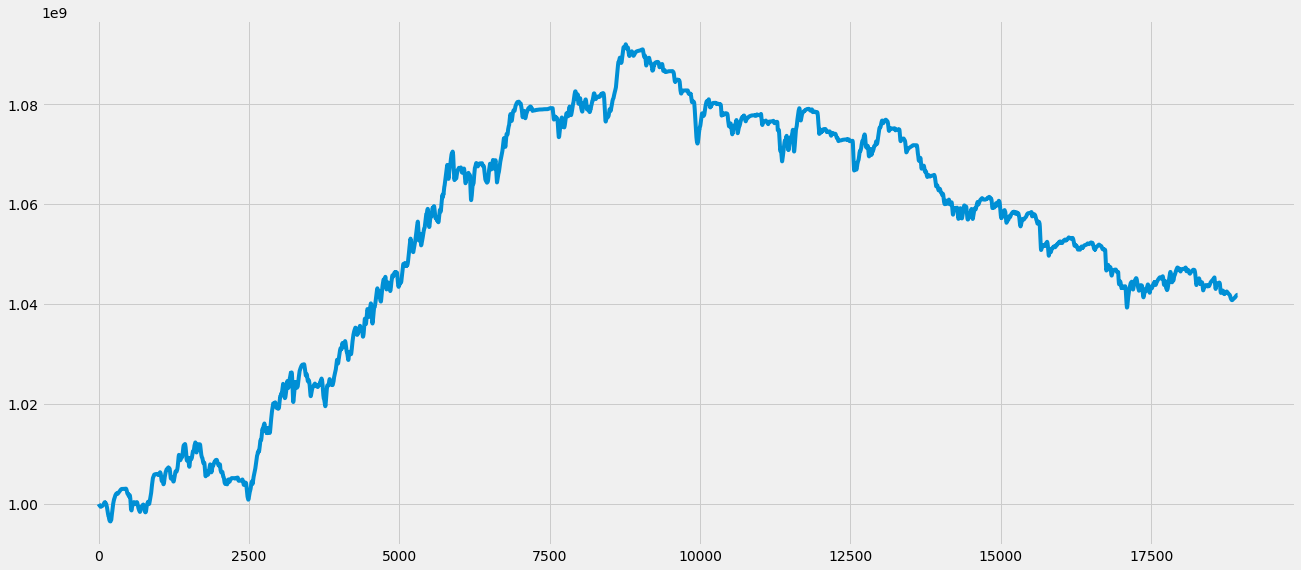

resultant budget:  1041863686.8106842
net profit:  41863686.810684204
number of short falling:  12700
number of panalty:  0


In [277]:
trading(holdout_result['Wind(t+18)'], holdout_result.prediction)

In [39]:
test_result['wind_baseline']  = data.Wind.mean()

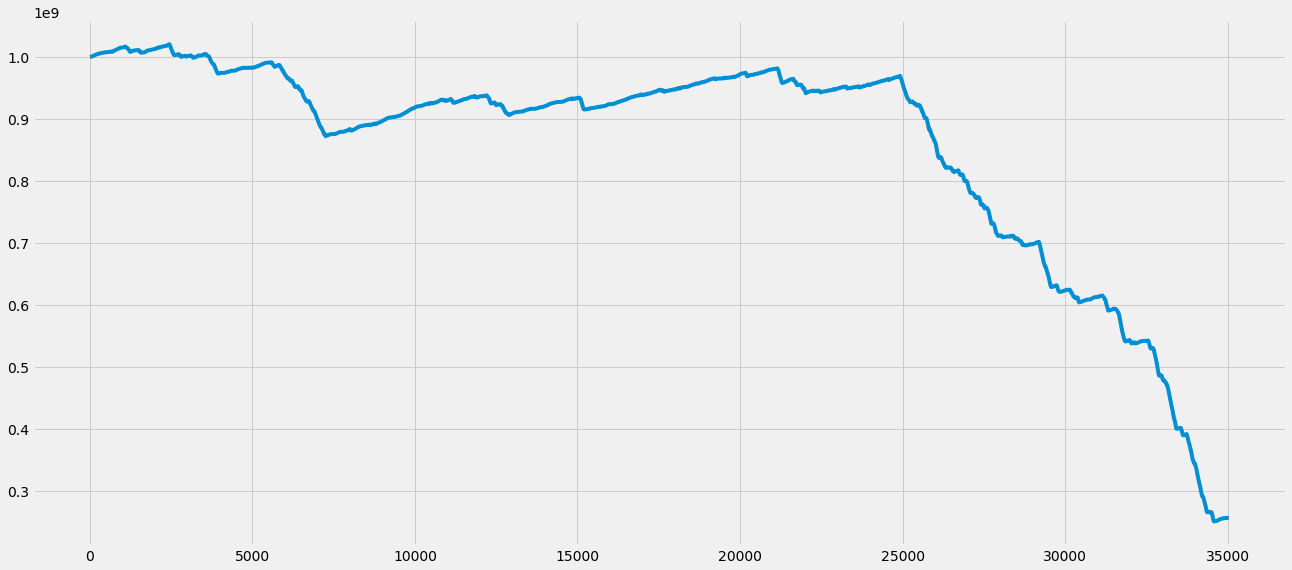

resultant budget:  256858933.63037205
net profit:  -743141066.369628
number of short falling:  15202
number of panalty:  0


In [40]:
trading(test_result['Wind(t+18)'], test_result.wind_baseline)